## **Sequoia Image Processing**
This notebook is built from https://github.com/rasmusfenger/micasense_imageprocessing_sequoia, which includes added functionality to the Micasense RedEdge image processing open library to enable Sequoia image processing.

### **Opening the raw image with pyplot**
Open the panel image with pyplot. Sequoia 16-bit images can be read directly into numpy arrays using the pyplot imread function and then displayed inline using the imshow function.

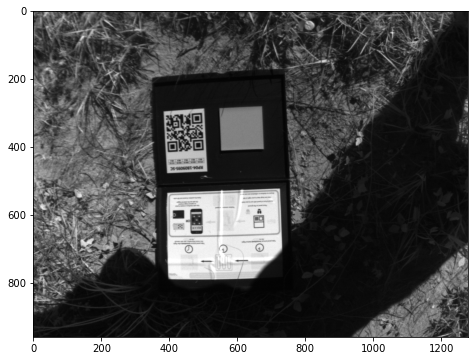

In [576]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math
import exiftool
import rasterio
from GPSPhoto import gpsphoto
import gdal
from osgeo.gdal import GetDriverByName, GDT_UInt16
%matplotlib inline

imagePath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0142')
imageName = os.path.join(imagePath,'IMG_200727_143153_0000_NIR.TIF')

# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
imageRaw=plt.imread(imageName)

# Display the image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(imageRaw, cmap='gray')
plt.show()

### **Adding a colorbar**
Using the plotting function in micasense.plotutils that adds a colorbar to the display to see changes in the values and the range of values more easily after various conversions. This function colorizes the grayscale images.

<Figure size 432x288 with 0 Axes>

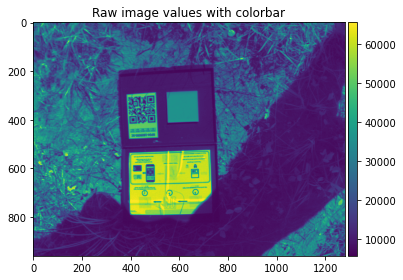

In [577]:
import micasense.plotutils as plotutils

# Optional: pick a color map that fits your viewing style
# one of 'gray, viridis, plasma, inferno, magma, nipy_spectral'
plotutils.colormap('viridis')

plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar');

### **Reading Sequoia Metadata**
Using Exiftool to read the metadata of an image, including standard image capture data (location,  UTC time, imager exposure, and gain), as well as Sequoia specific metadata

In [578]:
import micasense.metadata as metadata
from datetime import datetime, timedelta

exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'C:/exiftool/exiftool.exe'
# get image metadata
meta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
cameraMake = meta.get_item('EXIF:Make')
cameraModel = meta.get_item('EXIF:Model')
firmwareVersion = meta.get_item('EXIF:Software')
bandName = meta.get_item('XMP:BandName')
lat = meta.get_item('EXIF:GPSLatitude')
latref = meta.get_item('EXIF:GPSLatitudeRef')
lon = meta.get_item('EXIF:GPSLongitude')
lonref = meta.get_item('EXIF:GPSLongitudeRef')
alt = meta.get_item('EXIF:GPSAltitude')
str_time = meta.get_item('EXIF:DateTimeOriginal')
utc_time = datetime.strptime(str_time, "%Y:%m:%d %H:%M:%S")
fp_x_resolution = meta.get_item('EXIF:FocalPlaneXResolution')
fp_y_resolution = meta.get_item('EXIF:FocalPlaneYResolution')

print('{0} {1} firmware version: {2}'.format(cameraMake, 
                                             cameraModel, 
                                             firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISO')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Focal Length: {0}'.format(meta.get_item('EXIF:FocalLength')))
print('GPS Latitude: {0}'.format(meta.get_item('EXIF:GPSLatitude')))
print('GPS Latitude Ref: {0}'.format(meta.get_item('EXIF:GPSLatitudeRef')))
print('GPS Longitude: {0}'.format(meta.get_item('EXIF:GPSLongitude')))
print('GPS Longitude Ref: {0}'.format(meta.get_item('EXIF:GPSLongitudeRef')))
print('GPS Altitude: {0}'.format(meta.get_item('EXIF:GPSAltitude')))
print('GPS Altitude Ref: {0}'.format(meta.get_item('EXIF:GPSAltitudeRef')))
print('Str Time: {0}'.format(meta.get_item('EXIF:DateTimeOriginal')))
print('UTC Time:', utc_time)
print('Focal Plane X Resolution: {0} mm'.format(meta.get_item('EXIF:FocalPlaneXResolution')))
print('Focal Plane Y Resolution: {0} mm'.format(meta.get_item('EXIF:FocalPlaneYResolution')))

Parrot Sequoia firmware version: v1.7.1
Exposure Time: 0.0001846151427 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: NIR
Center Wavelength: 790.0 nm
Bandwidth: 40.0 nm
Focal Length: 3.979999908
GPS Latitude: 34.698871044175
GPS Latitude Ref: N
GPS Longitude: 76.6786910068389
GPS Longitude Ref: W
GPS Altitude: 34.36875451
GPS Altitude Ref: 1
Str Time: 2020:07:27 14:31:53
UTC Time: 2020-07-27 14:31:53
Focal Plane X Resolution: 266.6666559 mm
Focal Plane Y Resolution: 266.6666559 mm


### **Converting raw Sequoia images to irradiance** 
This step includes vignette correction and conversion of raw image to irradiance using the sensor calibration model.

First a vignette map is created following the procedure described in the [Application Note: How to correct vignetting in images](https://forum.developer.parrot.com/uploads/default/original/2X/b/b9b5e49bc21baf8778659d8ed75feb4b2db5c45a.pdf) The implemented code is written by [seanmcleod](https://forum.developer.parrot.com/t/vignetting-correction-sample-code/5614). The vignette map will be multiplied by the raw image values to reverse the darkening seen at the image corners. See the vignette_correction function for the details of the vignette parameters and their use.

    V = vignette_correction(meta, xDim, yDim)
The conversion of raw image to irradiance is done following the procedure described in the [Application note: Pixel value to irradiance using the sensor calibration model](https://forum.developer.parrot.com/uploads/default/original/2X/3/383261d35e33f1f375ee49e9c7a9b10071d2bf9d.pdf). The procedure is described in more details in this [document](https://onedrive.live.com/?authkey=%21ACzNLk1ORe37aRQ&cid=C34147D823D8DFEF&id=C34147D823D8DFEF%2115414&parId=C34147D823D8DFEF%21106&o=OneUp).

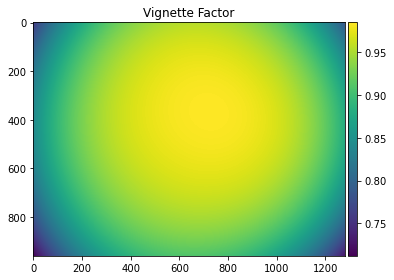

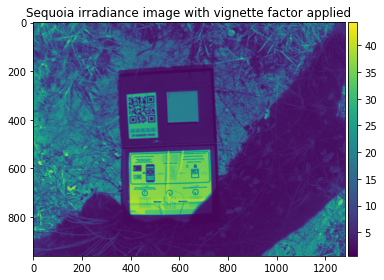

In [579]:
import micasense.plotutils as plotutils
import micasense.sequoiautils as msutils
SequoiaIrradiance, V = msutils.sequoia_irradiance(meta, imageRaw)
plotutils.plotwithcolorbar(V,'Vignette Factor');
plotutils.plotwithcolorbar(SequoiaIrradiance,'Sequoia irradiance image with vignette factor applied');

### **Sunshine calibration of Sequoia irradiance image**
Next step is to calculate the sunshine irradiance. This is used to normalise the images in an image dataset according to variations in the incomming solar radiation. The implemented code for retrieving the sunshine sensor data is written by [Yu-Hsuan Tu](https://github.com/dobedobedo/Parrot_Sequoia_Image_Handler/tree/master/Modules/Dependency).

Sunshine sensor irradiance:  33.75


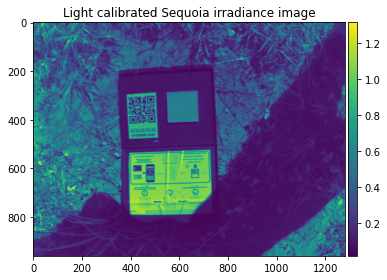

In [580]:
# Sunshine sensor Irradiance
SunIrradiance = msutils.GetSunIrradiance(meta)
print ('Sunshine sensor irradiance: ', SunIrradiance)

# Light calibrated sequoia irradiance
SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
plotutils.plotwithcolorbar(SequoiaIrradianceCalibrated,'Light calibrated Sequoia irradiance image');

### **Convert irradiance to reflectance**
The calibrated iradiance image can now be converted into reflectance. To do this, an image of a reflectance panel with known reflectance is required. The irradiance values of the panel image is then used to determine a scale factor between irradiance and reflectance.
In this case, we have our MicaSense calibrated reflectance panel and it's known reflectance of 62% in the band of interest. We will extract the area of the image containing the lambertian panel, determine it's radiance to reflectance scale factor, and then scale the whole image by that factor to get a reflectance image.

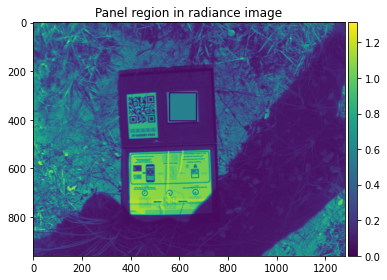

Mean Radiance in panel region: 0.573 W/m^2/nm/sr
Radiance to reflectance conversion factor: 0.445


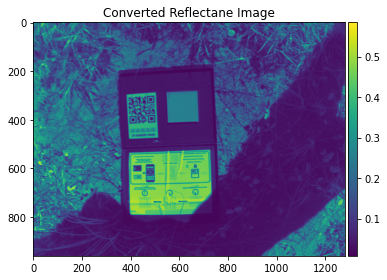

In [585]:
markedImg = SequoiaIrradianceCalibrated.copy()
ulx = 560 # upper left column (x coordinate) of panel area
uly = 290 # upper left row (y coordinate) of panel area
lrx = 670 # lower right column (x coordinate) of panel area
lry = 405 # lower right row (y coordinate) of panel area
cv2.rectangle(markedImg,(ulx,uly),(lrx,lry),(0,255,0),3)

# Our panel calibration by band (from MicaSense for our specific panel)
panelCalibration = { 
    "Green": 0.189, 
    "Red": 0.197, 
    "Red edge": 0.221, 
    "NIR": 0.255 
}

# Select panel region from radiance image
panelRegion = SequoiaIrradianceCalibrated[uly:lry, ulx:lrx]
plotutils.plotwithcolorbar(markedImg, 'Panel region in radiance image')
meanRadiance = panelRegion.mean()
print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))
panelReflectance = panelCalibration[bandName]
radianceToReflectance = panelReflectance / meanRadiance
print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance))

reflectanceImage = SequoiaIrradianceCalibrated * radianceToReflectance
plotutils.plotwithcolorbar(reflectanceImage, 'Converted Reflectane Image');

Now we will extract the same region and verify the reflectance in that region is what we expect. In the process, we will blur and visualize the extracted area to look for any trends. The area should have a very consistent reflectance. If a gradient or a high standard deviation (>3% absolute reflectance) is noticed across the panel area it is possible that the panel was captured under inconsistent lighting conditions (e.g. next to a wall or vehicle) or it was captured too close to the edge of the image where the optical calibration is the least accurate.

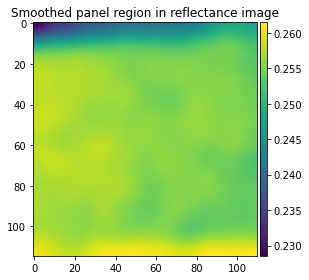

Min Reflectance in panel region: 0.17
Max Reflectance in panel region: 0.30
Mean Reflectance in panel region: 0.25
Standard deviation in region: 0.0080


In [586]:
panelRegionRaw = imageRaw[uly:lry, ulx:lrx]
panelRegionRefl = reflectanceImage[uly:lry, ulx:lrx]
panelRegionReflBlur = cv2.GaussianBlur(panelRegionRefl,(55,55),5)
plotutils.plotwithcolorbar(panelRegionReflBlur, 'Smoothed panel region in reflectance image')
print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.min()))
print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.max()))
print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.mean()))
print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl.std()))

### **Undistorting images**
Lens distortion effects can be removed from the image using the information in [Application Note: how to correct distortion in images](https://forum.developer.parrot.com/uploads/default/original/2X/e/ec302e9e4498cba5165711c2a52fa2c37be10431.pdf). The implemented code is originally written in Matlab by [muzammil360](https://github.com/muzammil360/SeqUDR) and has been modified and rewritten in Python.

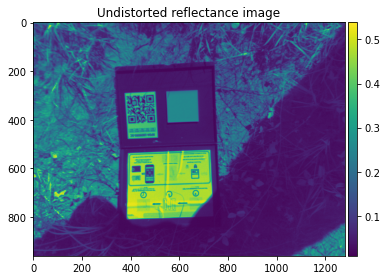

In [587]:
# correct for lens distortions to make straight lines straight
undistortedReflectance = msutils.correct_lens_distortion_sequoia(meta, reflectanceImage)
plotutils.plotwithcolorbar(undistortedReflectance, 'Undistorted reflectance image');

### **Converting raw flight images to reflectance based on the ```radiancetoReflectance``` value above**

#### **Sample image**

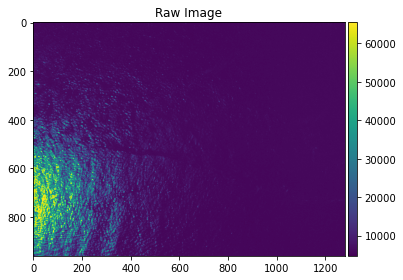

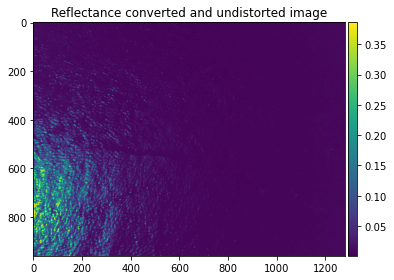

In [589]:
imagePath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
flightImageName = os.path.join(imagePath,'IMG_200727_140447_0000_NIR.TIF')
flightImageRaw=plt.imread(flightImageName)
plotutils.plotwithcolorbar(flightImageRaw, 'Raw Image')

flightImageMeta = metadata.Metadata(flightImageName, exiftoolPath=exiftoolPath)

SequoiaIrradiance, _ = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
# Sunshine sensor Irradiance
SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
# Light calibrated sequoia irradiance
SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
flightReflectanceImage = SequoiaIrradianceCalibrated * radianceToReflectance
flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
plotutils.plotwithcolorbar(flightUndistortedReflectance, 'Reflectance converted and undistorted image');

(array([6.50079e+05, 3.31137e+05, 6.02240e+04, 3.02210e+04, 2.03690e+04,
        1.54070e+04, 1.24250e+04, 1.02900e+04, 8.82100e+03, 7.98900e+03,
        7.08900e+03, 6.14100e+03, 5.60900e+03, 5.10100e+03, 4.65200e+03,
        4.24600e+03, 3.85500e+03, 3.53300e+03, 3.19600e+03, 3.02700e+03,
        2.65600e+03, 2.56300e+03, 2.38100e+03, 2.14900e+03, 2.02500e+03,
        1.91100e+03, 1.71100e+03, 1.62300e+03, 1.42900e+03, 1.35800e+03,
        1.22700e+03, 1.15900e+03, 1.10300e+03, 1.01100e+03, 1.05200e+03,
        9.03000e+02, 8.57000e+02, 8.19000e+02, 7.92000e+02, 7.02000e+02,
        6.85000e+02, 6.95000e+02, 6.55000e+02, 6.33000e+02, 6.65000e+02,
        7.39000e+02, 7.86000e+02, 6.98000e+02, 3.56000e+02, 4.60000e+01]),
 array([0.00079994, 0.0085064 , 0.01621287, 0.02391934, 0.0316258 ,
        0.03933227, 0.04703874, 0.0547452 , 0.06245167, 0.07015814,
        0.0778646 , 0.08557107, 0.09327754, 0.10098401, 0.10869047,
        0.11639693, 0.1241034 , 0.13180988, 0.13951634, 0.147222

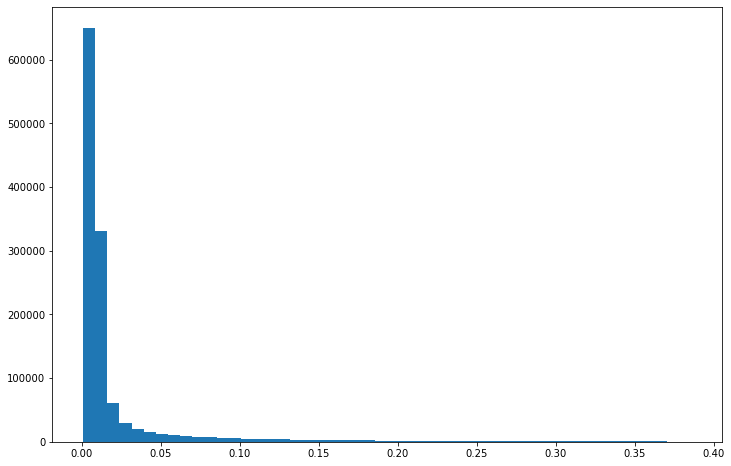

In [590]:
#plot histogram of reflectance values
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(flightUndistortedReflectance.flatten(), bins=50,)

### **Reflectance to turbidity**
Turbidity can be calculated from reflectance values in the NIR band using [A single algorithm to retrieve turbidity from remotely-sensed data in all coastal and estuarine waters](https://reader.elsevier.com/reader/sd/pii/S0034425714003654?token=749929E5DF7F12BBA191B38CB0C4A2DCD313AA0B664D157DC9FE59332F84198F272C69B1668301F913B7BB1E5078A4E6)

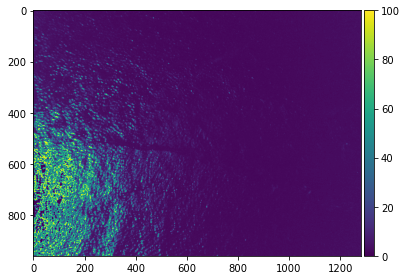

In [591]:
#single band turbidity analysis algorithm in the NIR band 
#turbidity = (a * Pw) /(1-Pw / c)
#Pw = water leaving reflectance 
#a and c are two wavelength-dependent calibration coefficients 
a = 366.14
c = 0.19563

turbidity = (a*flightUndistortedReflectance) / (1 - flightUndistortedReflectance / c)
turbidity[turbidity < 0] = 0
turbidity[turbidity > 100] = 100
plotutils.plotwithcolorbar(turbidity);

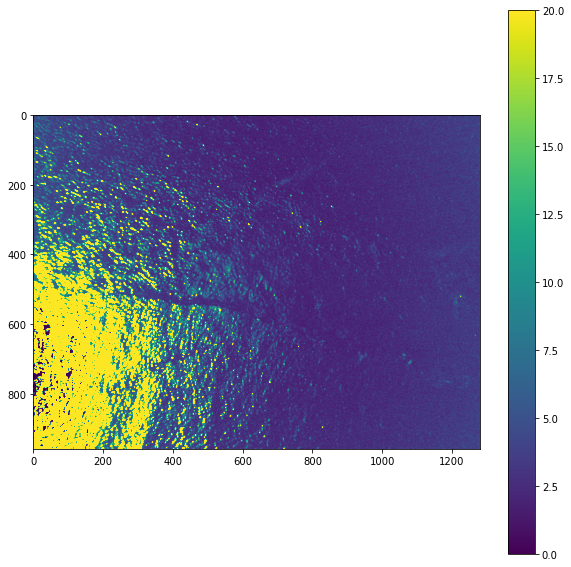

In [592]:
#plot with colorbar
fig, ax = plt.subplots(figsize=(10,10))
#im = ax.imshow(np.reshape(turbidity,(960, 1280)), vmin=0, vmax=30, cmap='jet')
im = ax.imshow(turbidity, vmin=0, vmax=20, cmap='viridis')
fig.colorbar(im)
#plt.savefig('turbidity_img100.tif')

(-0.5, 1279.5, 959.5, -0.5)

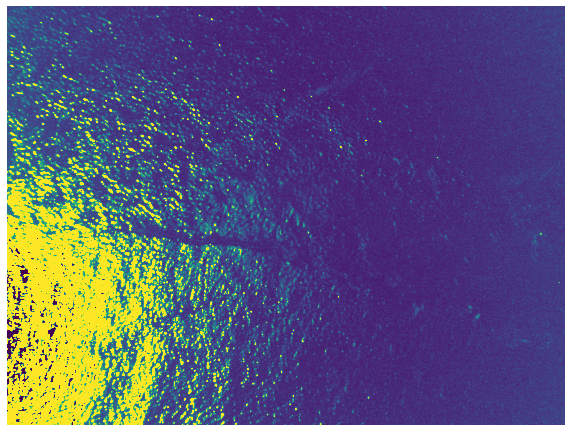

In [593]:
#plot without colorbar 
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(turbidity, vmin=0, vmax=20)
plt.axis('off')
#fig.savefig('turbidity_91_nocmbar.tif', bbox_inches='tight', pad_inches=0)

(array([1.93081e+05, 6.45688e+05, 1.50171e+05, 4.91430e+04, 2.66000e+04,
        1.79470e+04, 1.32090e+04, 1.05500e+04, 8.56400e+03, 7.32600e+03,
        6.28100e+03, 5.44000e+03, 4.82900e+03, 4.38900e+03, 3.87100e+03,
        3.53300e+03, 3.21800e+03, 2.93400e+03, 2.71700e+03, 2.45600e+03,
        2.37800e+03, 2.21600e+03, 2.06700e+03, 1.97500e+03, 1.84000e+03,
        1.71500e+03, 1.64500e+03, 1.53700e+03, 1.39100e+03, 1.32600e+03,
        1.20600e+03, 1.21000e+03, 1.20400e+03, 1.04400e+03, 1.00200e+03,
        1.00200e+03, 1.00700e+03, 9.15000e+02, 8.85000e+02, 8.23000e+02,
        7.83000e+02, 7.71000e+02, 7.49000e+02, 7.68000e+02, 6.41000e+02,
        6.68000e+02, 6.24000e+02, 6.05000e+02, 5.76000e+02, 3.22800e+04]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  7

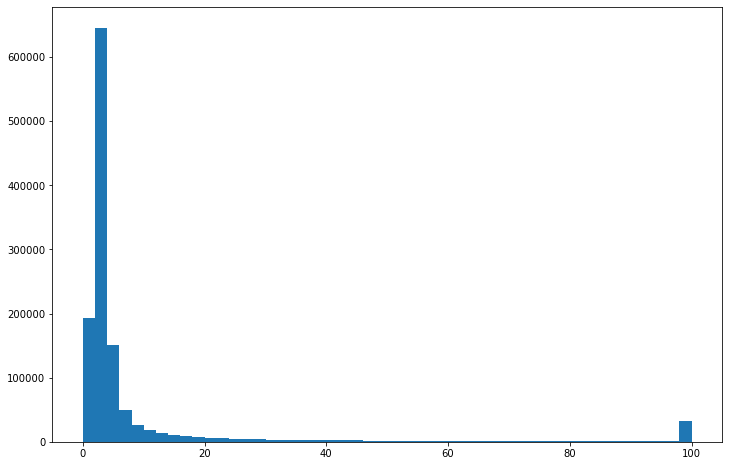

In [594]:
#plot histogram of turbidity values 
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(turbidity.flatten(), bins=50,)

### **Save all turbidity outputs as png files with a colorbar**
Save the turbidity outputs as individual images to use a "spot samples". Change the "turbidity" minimum and maximum values based on visualization needs. 

In [595]:
#inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
#outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Turbidity')

#a = 366.14
#c = 0.19563

#for filename in os.listdir(inputPath):
    #if filename.endswith("NIR.TIF"):
        #imageName = os.path.join(inputPath, filename)
        #flightImageRaw=plt.imread(imageName)
        #flightImageMeta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
        #SequoiaIrradiance, _ = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
        #SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
        #SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
        #flightReflectanceImage = SequoiaIrradianceCalibrated * radianceToReflectance
        #flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
        #turbidity = (a*flightUndistortedReflectance) / (1 - flightUndistortedReflectance / c)
        #change these values below to adjust the colorbar scale
        #turbidity[turbidity < 0] = 0
        #turbidity[turbidity > 50] = 50
        #fig, ax = plt.subplots(figsize=(10,10))
        #im = ax.imshow(turbidity, vmin=0, vmax=50, cmap='viridis')
        #fig.colorbar(im)
        #outputname = filename.split('.')[0] + '_sample' + '.png'
        #plt.savefig(outputname, format='png')

## **Converting all Sequoia images to reflectance and turbidity**

### **Helper functions**
Adapted from https://github.com/marrs-lab/ocean_color

In [596]:
def decdeg2dms(dd):
    is_positive = dd >= 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)

def write_exif_csv(inputPath, outputPath):
    header = "SourceFile,\
        GPSDateStamp,GPSTimeStamp,\
        GPSLatitude,GPSLatitudeRef,\
        GPSLongitude,GPSLongitudeRef,\
        GPSAltitude,GPSAltitudeRef,\
        FocalLength,\
        XResolution,YResolution,ResolutionUnits\n"
    lines = [header]
    for filename in os.listdir(inputPath):
        if filename.endswith("NIR.TIF"):
            imageName = os.path.join(inputPath, filename)
            fullOutputPath = os.path.join(outputPath, filename)
            meta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
            lat = meta.get_item('EXIF:GPSLatitude')
            latref = meta.get_item('EXIF:GPSLatitudeRef')
            lon = meta.get_item('EXIF:GPSLongitude')
            lonref = meta.get_item('EXIF:GPSLongitudeRef')
            alt = meta.get_item('EXIF:GPSAltitude')
            fp_x_resolution = meta.get_item('EXIF:FocalPlaneXResolution')
            fp_y_resolution = meta.get_item('EXIF:FocalPlaneYResolution')
            focal_length = meta.get_item('EXIF:FocalLength')
            str_time = meta.get_item('EXIF:DateTimeOriginal')
            utc_datetime = datetime.strptime(str_time, "%Y:%m:%d %H:%M:%S")
            latdeg, latmin, latsec = decdeg2dms(lat)
            londeg, lonmin, lonsec = decdeg2dms(lon)
            latdir = 'North'
            if latdeg < 0:
                latdeg = -latdeg
                latdir = 'South'
            londir = 'West'
            if londeg < 0:
                londeg = -londeg
                londir = 'East'

            linestr = '"{}",'.format(fullOutputPath)
            linestr += utc_datetime.strftime("%Y:%m:%d,%H:%M:%S,")
            linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
            linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
            linestr += '"{}",'.format(meta.get_item('EXIF:FocalLength'))
            linestr += '{},{},mm'.format(fp_x_resolution,fp_x_resolution)
            linestr += '\n'
            lines.append(linestr)
        
    fullCsvPath = os.path.join(outputPath,'log.csv')
    with open(fullCsvPath, 'w') as csvfile:
        csvfile.writelines(lines)
    
    return(fullCsvPath)

In [597]:
def array2raster(output, dataset, array, index):
    with rasterio.Env():
        with rasterio.open(dataset, 'r') as src:
            profile = src.profile
        
        lat = img_metadata[index]['Latitude']
        lon = img_metadata[index]['Longitude']
        
        #transform from bounds: west, south, east, north, width, height
        tsfm = rasterio.transform.from_bounds(lon-0.0001, lat-0.0002, lon+0.0004, lat+0.0002, profile['width'], profile['height'])
        crs = rasterio.crs.CRS({"init": "epsg: 4326"})
        profile.update(
            dtype=rasterio.uint8,
            transform = tsfm,
            crs=crs)
        with rasterio.open(output, 'w', **profile) as dst:
            dst.write(array.astype(rasterio.uint8), 1)

In [598]:
def save_reflectance_imgs (outfilename, array, photometric='MINISBLACK'):
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]
    outRaster = driver.Create(outfilename, cols, rows, band_num, GDT_UInt16, options = ['INTERLEAVE=BAND', 'COMPRESS=DEFLATE',f'PHOTOMETRIC={photometric}' ])
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array*32768)
        else:
            outband.WriteArray(array[:,:,b])
    outband.FlushCache()
    outRaster = None
    

In [599]:
def load_img_fn_and_meta(img_dir, count, start):
    i = 0
    j= 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.TIF"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            img_metadata.append(gpsphoto.getGPSData(file))
            j += 1
        i += 1
    return(imgs, img_metadata)

In [600]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

In [601]:
def retrieve_imgs_and_metadata(img_dir, count=None, start=0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    imgs = load_images(img_fns)
    imgs = np.array(imgs) / 32768
    print('Output shape is: ', imgs.shape)
    return(imgs, img_metadata)

In [602]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.65, band=1, return_imgs=False, visualize=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        #if np.mean(imgs[i,0]) > 0.2:
            #continue
        spectra = []
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0] = 1
        flat_array[flat_array < 0.0001 ] = 1
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        for img_idx in range(0,1):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                img_sorted.append(sorted_band)
            #mean of darkest pixels from each band and append to spectra
            spectra.append(np.mean(sorted_band[idx]))
            spectra.append(np.median(sorted_band[idx]))
            spectra.append(np.min(sorted_band[idx]))
            spectra.append(np.max(sorted_band[idx]))
            #if img_idx == 0:
                #spectra.append(np.mean(sorted_band[idx]))
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
        
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)    

In [603]:
def remove_bright_pix(im, lowest_percent=0.05, band=0):
    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=0, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [604]:
def turbidity_img(reflectance_img):
    a = 366.14
    c = 0.19563
    
    turbidity_list = []
    full_img_flat = reflectance_img.reshape(1,-1)
    for i in range(full_img_flat.shape[-1]):
        turbidity = (a * full_img_flat[0,i]) / (1 - full_img_flat[0,i] / c)
        #turbidity[turbidity < 0] = 0
        #turbidity[turbidity > 100] = 100
        turbidity_list.append(turbidity)
    turbidity = np.array(turbidity_list)
    return(turbidity)

In [605]:
def visualize_turbidity(im, reflectance_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_turbidity_img = turbidity_img(reflectance_spectra)
        
        ims = ax[i].imshow(turbidity_img, interpolation='nearest', cmap='jet', vmax=100)
        ax[i].set_title(lowest_percent)
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

In [606]:
def visualize_darkest_pixels(im, lowest_percent=0.5, only_img=False):
    band_names = ['nir']
    colors = ['red']
    
    fig, ax = plt.subplots(figsize=(16,14))
    
    ims = ax.imshow(im[0,:,:], cmap='jet', vmax=0.02, vmin=0)
    ax.set_title(band_names[0])
    fig.colorbar(ims, fraction=0.046, pad=0.04)
    ax.set_xticks([])
    ax.set_yticks([])
        
    fig.show()
    
    if not only_img:
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        
        fig, ax = plt.subplots(figsize=(16,14))
    
        ims = ax.imshow(dark_pix[0].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=0.2, vmin=0)
        ax.set_title(band_names[0])
        fig.colorbar(ims, ax=ax, fraction=0.046, pad=0.04)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.show()
        
        fig, ax = plt.subplots(figsize=(12,8))
        ax.hist(dark_pix[0].flatten(), density=True, bins=50, color=colors[0], alpha=0.5)
            
        #for i in range(0,1):
            #print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)
        
        return(dark_pix.reshape(1,im.shape[1], im.shape[2]))
    else:
        return(None)

### **Save raw image EXIF data to open image locations in GIS**

In [607]:
inputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
fullCsvPath = write_exif_csv(inputPath, outputPath)

In [608]:
inputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141','Reflectance')
fullCsvPath = write_exif_csv(inputPath, outputPath)

In [609]:
inputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141','Turbidity')
fullCsvPath = write_exif_csv(inputPath, outputPath)

### **Add metadata back to raw images**

In [611]:
! exiftool -csv="data/Sequoia/200727areabEM02/EP-01-07667_0141/log.csv" -overwrite_original data/Sequoia/200727areabEM02/EP-01-07667_0141

    1 directories scanned
  133 image files updated


In [612]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
img_metadata = []
imgs = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs.append(file)
    img_metadata.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[13])

133 ./data/Sequoia/200727areabEM02/EP-01-07667_0141/IMG_200727_140942_0034_NIR.TIF


In [613]:
img_metadata[13]

{'Latitude': 34.704527777777784,
 'Longitude': -76.68555277777779,
 'Altitude': 82.2,
 'UTC-Time': '14:9:42',
 'Date': '07/27/2020'}

### **Convert raw NIR images to reflectance**
The reflectance images can then be used to generate a turbidity shapefile of the average turbidity based on the spectra calculated from ```calculate spectra from darkest pixel```

In [614]:
inputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141','Reflectance')

for filename in os.listdir(inputPath):
    if filename.endswith("NIR.TIF"):
        imageName = os.path.join(inputPath, filename)
        fullOutputPath = os.path.join(outputPath, filename)
        #im = gdal.Open(imageName)
        flightImageRaw=plt.imread(imageName)
        flightImageMeta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
        SequoiaIrradiance, _ = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
        SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
        SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
        flightReflectanceImage = SequoiaIrradianceCalibrated * radianceToReflectance
        flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
        save_reflectance_imgs(fullOutputPath, flightUndistortedReflectance)

#### **Add metadata back to reflectance images**

In [615]:
! exiftool -csv="data/Sequoia/200727areabEM02/EP-01-07667_0141/Reflectance/log.csv" -overwrite_original data/Sequoia/200727areabEM02/EP-01-07667_0141/Reflectance

    1 directories scanned
  133 image files updated


In [616]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141','Reflectance')
img_metadata_reflectance = []
imgs_reflectance = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs_reflectance.append(file)
    img_metadata_reflectance.append(gpsphoto.getGPSData(file))
print(len(imgs_reflectance), imgs_reflectance[0])

133 ./data/Sequoia/200727areabEM02/EP-01-07667_0141/Reflectance/IMG_200727_142247_0068_NIR.TIF


In [617]:
img_metadata_reflectance[0]

{'Latitude': 34.70236666666667,
 'Longitude': -76.68615555555556,
 'Altitude': 74,
 'UTC-Time': '14:22:47',
 'Date': '07/27/2020'}

### **Filter out bright pixels**

In [618]:
reflectance_output = 'data/Sequoia/200727areabEM02/EP-01-07667_0141/Reflectance'
reflectance_imgs, reflectance_imgs_metadata = retrieve_imgs_and_metadata(reflectance_output)

/home/mch87/anaconda3/envs/sequoia_new/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (133, 1, 960, 1280)


In [619]:
reflectance_imgs_metadata[0]

{'Latitude': 34.70236666666667,
 'Longitude': -76.68615555555556,
 'Altitude': 74,
 'UTC-Time': '14:22:47',
 'Date': '07/27/2020'}

In [620]:
reflectance_imgs.shape[0]

133

(array([3.26085e+05, 6.66482e+05, 9.55910e+04, 2.95630e+04, 1.74750e+04,
        1.25470e+04, 9.63600e+03, 7.67300e+03, 6.29400e+03, 5.34400e+03,
        4.64900e+03, 4.09700e+03, 3.65800e+03, 3.10400e+03, 2.87300e+03,
        2.59400e+03, 2.33100e+03, 2.11400e+03, 1.90300e+03, 1.74400e+03,
        1.57300e+03, 1.48600e+03, 1.36300e+03, 1.20400e+03, 1.16200e+03,
        1.10700e+03, 9.81000e+02, 9.26000e+02, 8.93000e+02, 8.59000e+02,
        8.01000e+02, 7.42000e+02, 7.16000e+02, 7.15000e+02, 6.72000e+02,
        5.82000e+02, 5.88000e+02, 5.80000e+02, 4.98000e+02, 5.14000e+02,
        4.80000e+02, 5.32000e+02, 5.21000e+02, 5.32000e+02, 5.20000e+02,
        5.87000e+02, 7.02000e+02, 6.01000e+02, 5.05000e+02, 1.01000e+02]),
 array([0.00091553, 0.00360901, 0.00630249, 0.00899597, 0.01168945,
        0.01438293, 0.01707642, 0.0197699 , 0.02246338, 0.02515686,
        0.02785034, 0.03054382, 0.0332373 , 0.03593079, 0.03862427,
        0.04131775, 0.04401123, 0.04670471, 0.04939819, 0.052091

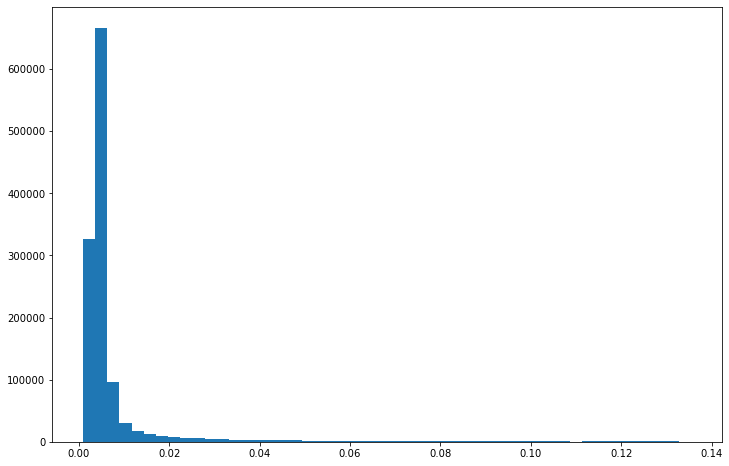

In [621]:
#plot histogram of reflectance values
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(reflectance_imgs[0].flatten(), bins=50,)

In [622]:
reflectance_imgs[0].shape

(1, 960, 1280)

In [623]:
reflectance_imgs[0].size

1228800

In [624]:
len(reflectance_imgs)

133

In [625]:
reflectance_imgs[1].shape

(1, 960, 1280)

/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


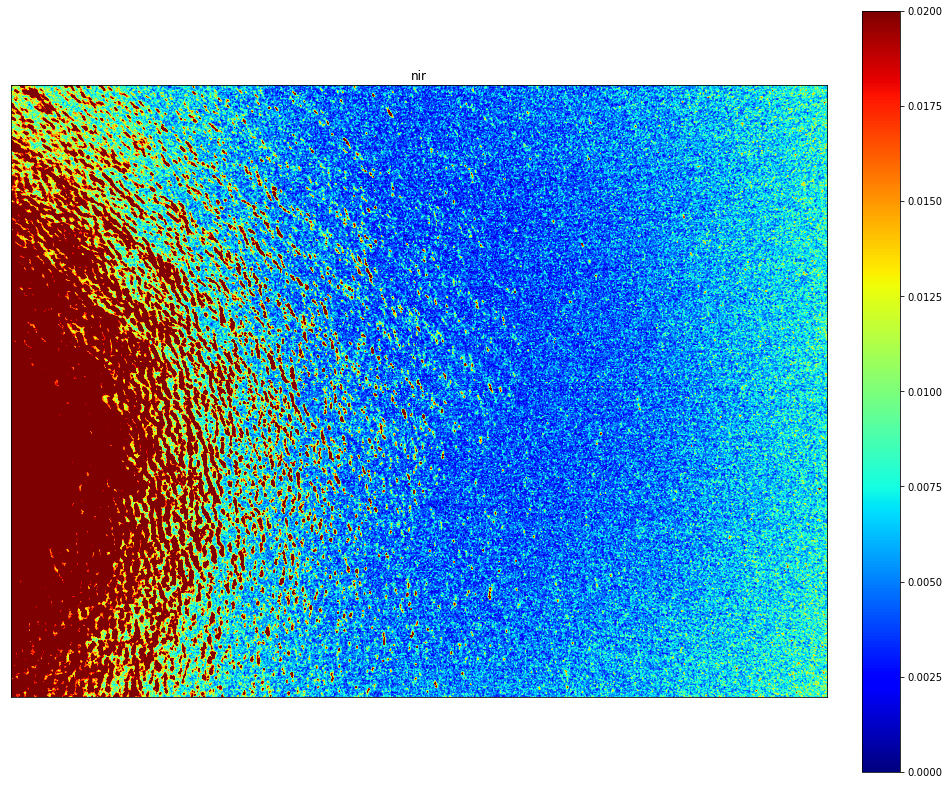

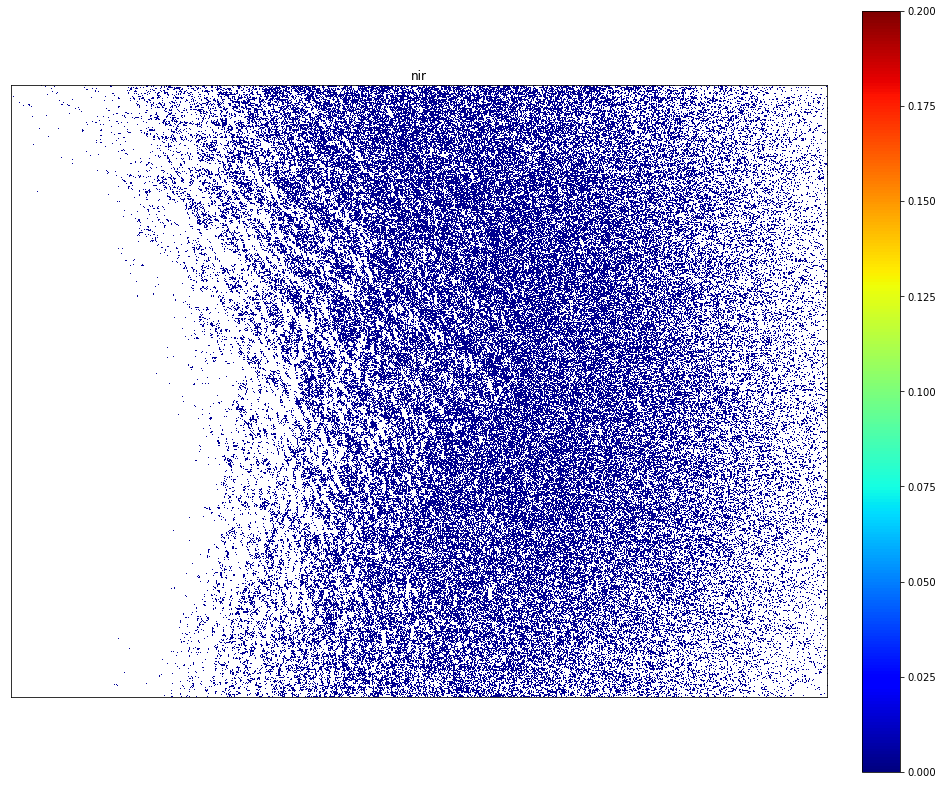

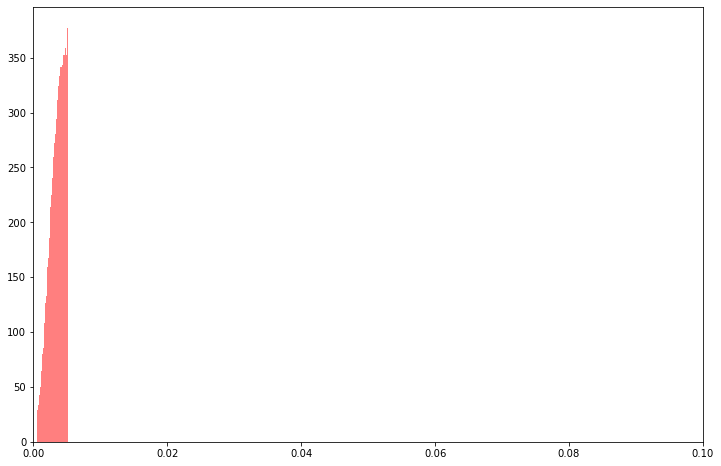

In [647]:
lowest_percent = 0.65
#lowest_percent = 0.35
dark_pix_dark = visualize_darkest_pixels(reflectance_imgs[-1], lowest_percent=lowest_percent)

In [648]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.00351654])

### **Calculate spectra from the darkest pixels in each image to generate turbidity shapefiles**

0 0.0032958984375
1 0.003326416015625
2 0.0040283203125
3 0.00341796875
4 0.003997802734375
5 0.0037841796875
6 0.004638671875
7 0.004486083984375
8 0.003082275390625
9 0.003204345703125
10 0.004486083984375
11 0.0032958984375
12 0.004241943359375
13 0.00323486328125
14 0.003692626953125
15 0.004364013671875
16 0.003326416015625
17 0.006103515625
18 0.004547119140625
19 0.01129150390625
20 0.00286865234375
21 0.0050048828125
22 0.00506591796875
23 0.00372314453125
24 0.004364013671875
25 0.003814697265625
26 0.003387451171875
27 0.003082275390625
28 0.00433349609375
29 0.0042724609375
30 0.003662109375
31 0.004180908203125
32 0.003692626953125
33 0.004302978515625
34 0.003997802734375
35 0.002899169921875
36 0.004150390625
37 0.005035400390625
38 0.007537841796875
39 0.003448486328125
40 0.00341796875
41 0.003204345703125
42 0.00323486328125
43 0.0045166015625
44 0.003662109375
45 0.00372314453125
46 0.007293701171875
47 0.003631591796875
48 0.004180908203125
49 0.003662109375
50 0.003

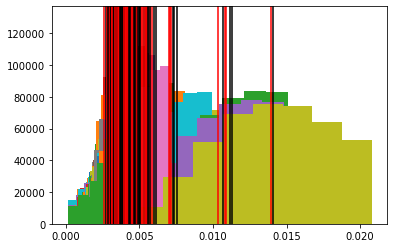

In [649]:
lowest_percent = 0.65
#lowest_percent = .35
reflectance_spectra, reflectance_idxs = calculate_spectra_from_darkest_px(reflectance_imgs, lowest_percent=lowest_percent, band=0, visualize=True)

In [650]:
reflectance_spectra[0]

[0.003234059328124637, 0.0032958984375, 0.00091552734375, 0.003875732421875]

In [651]:
reflectance_spectra_array = np.array(reflectance_spectra)

### **Calculate turbidity from spectra calculated from darkest pixels above**

In [652]:
#test - calculate turbidity from average spectra (calculated from the darkest pixel) to get one turbidity value per image
#TO DO - convert this to a function in helper functions
a = 366.14
c = 0.19563
turbidity_list = []
for spectra in reflectance_spectra_array:
    turbidity = (a * spectra) / (1 - spectra / c)
    turbidity_list.append(turbidity)
#turbidity_list = np.array(turbidity_list)


In [1]:
#turbidity_list

In [654]:
turbid_mean = []
turbid_median = []
turbid_min = []
turbid_max = []
for turbid in turbidity_list:
    turbid_mean.append(turbid[0])
    turbid_median.append(turbid[1])
    turbid_min.append(turbid[2])
    turbid_max.append(turbid[3])

In [655]:
#reflectance_spectra

In [656]:
spectra_mean = []
spectra_median = []
spectra_min = []
spectra_max = []
for spectra in reflectance_spectra:
    spectra_mean.append(spectra[0])
    spectra_median.append(spectra[1])
    spectra_min.append(spectra[2])
    spectra_max.append(spectra[3])

In [657]:
#turbid_mean

In [658]:
#spectra_mean

In [659]:
turbid_mean = np.array(turbid_mean)
turbid_median = np.array(turbid_median)
turbid_min = np.array(turbid_min)
turbid_max = np.array(turbid_max)

In [660]:
turbid_mean.shape

(133,)

In [661]:
spectra_mean = np.array(spectra_mean)
spectra_median = np.array(spectra_median)
spectra_min = np.array(spectra_min)
spectra_max = np.array(spectra_max)

In [662]:
spectra_mean.shape

(133,)

### **Export per image spectra and turbidity values as shapefiles with image metadata**

In [663]:
from datetime import datetime
import pandas as pd
import geopandas as gpd

def convert_to_df(turbidity_mean, turbidity_median, turbidity_min, turbidity_max, spectra_mean, reflectance_imgs_metadata):
    dates = []
    for im in reflectance_imgs_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']
        
        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        dates.append(date_time_obj)
    lons = []
    lats = []
    for im in reflectance_imgs_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        
    #y = np.arange(turbidity_list.shape[0],dtype=int)
    #x = [data for data in turbidity_list]  
    turbidity_df = pd.DataFrame(
    {'turbidity mean': turbidity_mean,
    'turbidity median': turbidity_median,
    'turbidity min': turbidity_min,
    'turbidity max': turbidity_max,
    'spectra mean': spectra_mean,
    'Latitude': lats,
    'Longitude': lons,
    'time' : dates})
    
    turbidity_gdf = gpd.GeoDataFrame(
        turbidity_df, geometry=gpd.points_from_xy(turbidity_df.Longitude, turbidity_df.Latitude))
    return(turbidity_gdf)

In [665]:
gdf = convert_to_df(turbid_mean, turbid_median, turbid_min, turbid_max, spectra_mean, [reflectance_imgs_metadata[i] for i in reflectance_idxs])

gdf.head()

turbidity mean  turbidity median  turbidity min  turbidity max  \
0        1.204023          1.227440       0.336787       1.447743   
1        1.187284          1.239001       0.044723       1.622609   
2        1.455773          1.505939       0.078301       1.880600   
3        1.213626          1.273709       0.044723       1.716214   
4        1.453826          1.494292       0.257921       1.821806   

   spectra mean   Latitude  Longitude                time  \
0      0.003234  34.702367 -76.686156 2020-07-27 14:22:47   
1      0.003190  34.702414 -76.682694 2020-07-27 14:26:47   
2      0.003897  34.705350 -76.683242 2020-07-27 14:11:00   
3      0.003259  34.701486 -76.681558 2020-07-27 14:27:17   
4      0.003892  34.705844 -76.683258 2020-07-27 14:10:56   

                     geometry  
0  POINT (-76.68616 34.70237)  
1  POINT (-76.68269 34.70241)  
2  POINT (-76.68324 34.70535)  
3  POINT (-76.68156 34.70149)  
4  POINT (-76.68326 34.70584)

<AxesSubplot:>

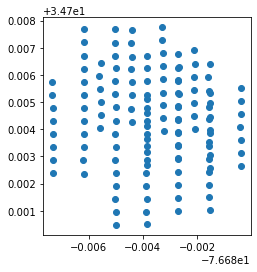

In [666]:
gdf.plot()

In [667]:
gdf.time = gdf.time.astype(str)
#gdf.turbidity = gdf.turbidity.astype(str)
gdf.to_file('data/Sequoia/200727areabEM02/EP-01-07667_0141/Turbidity/turbidity_35.shp')

### **Inspect full images**

In [668]:
full_img = reflectance_imgs[0]

In [669]:
full_img.shape,reflectance_imgs.shape

((1, 960, 1280), (133, 1, 960, 1280))

In [670]:
full_img_flat = turbidity_img(full_img)

In [671]:
np.nanmax(full_img_flat), np.nanmedian(full_img_flat), np.nanmean(full_img_flat)

(161.75787412949242, 1.634297025385235, 3.5218242802261237)

In [672]:
full_img_flat.shape

(1228800,)

In [673]:
len(full_img_flat)

1228800

In [674]:
full_turbid_img = np.reshape(full_img_flat, (full_img.shape[1], full_img.shape[2]))

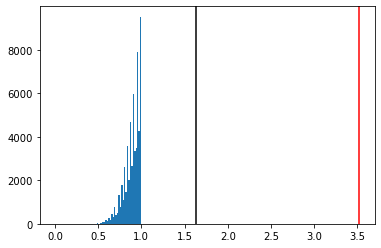

In [675]:
plt.hist(full_turbid_img.flatten(), range=(0,1), bins=60)
plt.axvline(np.nanmedian(full_turbid_img), c='black')
plt.axvline(np.nanmean(full_turbid_img), c='red')
plt.show()

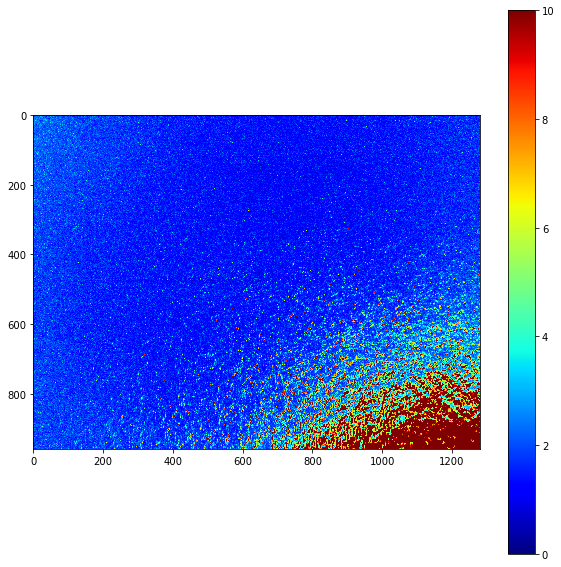

In [676]:
import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(full_turbid_img, interpolation='nearest', cmap='jet', vmin=0, vmax=10)
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='yellow')

fig.colorbar(im)

### **Convert NIR reflectance images to turbidity**

In [677]:
imgs[0]

'./data/Sequoia/200727areabEM02/EP-01-07667_0141/IMG_200727_142247_0068_NIR.TIF'

In [679]:
flat_array = reflectance_imgs[0].reshape(1,-1)
flat_array.shape[-1]

1228800

In [681]:
flat_array.shape

(1, 1228800)

In [691]:
spectra = []
for i in range(flat_array.shape[-1]):
    spectra.append(flat_array[0,i])

In [692]:
np.nanmax(spectra)

0.135589599609375

In [678]:
#TO DO - add in turbid[turbid > 100] =  100
#TO DO - fix naming conventions for fullOutputPath


import rasterio

inputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141')
outputPath = os.path.join('.','data','Sequoia','200727areabEM02','EP-01-07667_0141','Turbidity')

a = 366.14
c = 0.19563
index = 0

    #for file in imgs:
    #imageName = os.path.join(inputPath, filename)
    #fullOutputPath = os.path.join(outputPath, filename)
for im in reflectance_imgs:
    flat_array = im.reshape(1,-1)
    turbidity = []
    for i in range(flat_array.shape[-1]):
        turbid = (a * flat_array[0,i]) / (1 - flat_array[0,i] / c)
        turbidity.append(turbid)
    turbidity = np.array(turbidity)
    full_img = np.reshape(turbidity, (im.shape[1], im.shape[2]))
    fullOutputPath = os.path.join(outputPath, str(index)+ ".tif")
    index += 1
    array2raster(fullOutputPath, imageName, full_img, index)

/home/mch87/anaconda3/envs/sequoia_new/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


IndexError: list index out of range

In [158]:
#check transform/profile for newly created turbidity images
import rasterio
with rasterio.Env():
    with rasterio.open('data/Sequoia/200728areabEM01/DCIM/EP-01-07667_0142/Turbidity/1.tif') as src:
        profile = src.profile
    print(profile)
    crs = rasterio.crs.CRS({"init": "epsg:4326"})
    
    profile.update(
        dtype=rasterio.uint8,
        crs=crs)
    print(profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.906250000018652e-07, 0.0, -76.67185277777779,
       0.0, -4.166666666656956e-07, 34.70344722222222), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.906250000018652e-07, 0.0, -76.67185277777779,
       0.0, -4.166666666656956e-07, 34.70344722222222), 'tiled': False, 'interleave': 'band'}


In [22]:
#test script to determine proper transform from bounds values if needed
import rasterio
with rasterio.Env():
    with rasterio.open('data/Sequoia/200717areaaPM01/0016/IMG_200717_112523_0207_NIR.TIF') as src:
        profile = src.profile
    print(profile)
    pix_size = 0.071
    width = 1280
    height = 960
    heading=0
    lat = img_metadata[0]['Latitude']
    lon = img_metadata[0]['Longitude']
    #transform from bounds: west, south, east, north, width, height
    #tsfm = rasterio.transform.from_bounds(lon, lat-(pix_size*height), lon+(pix_size*width), lat, profile['width'], profile['height'])
    #pix_size = 0.1
    #heading=0
    #lat = img_metadata[-1]['Latitude']
    #lon = img_metadata[-1]['Longitude']
    
    #tsfm = rasterio.transform.from_origin(lon, lat, 0.266, 0.266)
    tsfm = rasterio.transform.from_bounds(lon-0.0001, lat-0.0002, lon+0.0004, lat+0.0002, profile['width'], profile['height'])
    print(tsfm)
    crs = rasterio.crs.CRS({"init": "epsg:4326"})
    
    profile.update(
        dtype=rasterio.uint8,
        transform = tsfm,
        crs=crs)
    print(profile)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}
| 0.00, 0.00,-76.67|
| 0.00,-0.00, 34.65|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.906250000018652e-07, 0.0, -76.6731388888889,
       0.0, -4.166666666656956e-07, 34.65432777777777), 'tiled': False, 'interleave': 'band'}


In [75]:
tsfm

NameError: name 'tsfm' is not defined

In [17]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.90625000000755e-06, 0.0, -76.6740388888889,
       0.0, -4.166666666671759e-06, 34.656127777777776), 'tiled': False, 'interleave': 'band'}

In [103]:
#another test script to inspect transform/profile of new turbidity images
import rasterio
infile = 'data/Sequoia/200717areaaPM05/0001/Turbidity/IMG_200717_131240_0035_NIR.TIF'
dataset = rasterio.open(infile)
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))


print('All raster metadata:')
print(metadata)
print('\n')

Image filename: data/Sequoia/200717areaaPM05/0001/Turbidity/IMG_200717_131240_0035_NIR.TIF

Number of bands in image: 1

Image size is: 960 rows x 1280 columns

Raster description: (None,)

Raster driver: GTiff

Image projection:
EPSG:4326 

Image geo-transform:
| 0.00, 0.00,-76.68|
| 0.00,-0.00, 34.66|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.90625000000755e-06, 0.0, -76.67984444444446,
       0.0, -4.166666666671759e-06, 34.65955)}




In [2]:
dataset.bounds

BoundingBox(left=0.0, bottom=960.0, right=1280.0, top=0.0)

### **Add metadata back to turbidity images**
This currently will not work because the naming conventions from ```convert NIR reflectance images to turbidity``` are not the same as the image names in the log.csv file. 

In [283]:
! exiftool -csv="data/Sequoia/200717areaaPM06/0001/Turbidity/log.csv" -overwrite_original data/Sequoia/200717areaaPM06/0001/Turbidity

    1 directories scanned
  245 image files updated


In [284]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200717areaaPM06','0001','Turbidity')
img_metadata_turbidity = []
imgs = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs.append(file)
    img_metadata_turbidity.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[0])

245 ./data/Sequoia/200717areaaPM06/0001/Turbidity/IMG_200717_134849_0206_NIR.TIF


In [285]:
img_metadata_turbidity[0]

{'Latitude': 34.65493055555555,
 'Longitude': -76.68227777777778,
 'Altitude': 117.9,
 'UTC-Time': '13:48:49',
 'Date': '07/17/2020'}

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}


/home/mch87/anaconda3/envs/sequoia/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


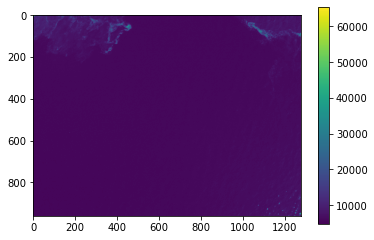

In [12]:
import rasterio
infile = 'data/Sequoia/200717areaaPM01/0016/IMG_200717_112523_0207_NIR.TIF'
with rasterio.open(infile) as src:
    print(src.profile)
    turbidity = src.read(1)
plt.imshow(turbidity, cmap='viridis')
plt.colorbar()

In [ ]:
#TO DO - filter out bright pixels for full image turbidity 
#TO DO - filter out bad images
#TO DO - add in-situ turbidity data to the turbidity geodataframe above? correlate by coordinates or time?